In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from pydrake.geometry.optimization import (
    HPolyhedron, Hyperellipsoid, Iris, IrisOptions, VPolytope, IrisMultiContainment
)
# from pydrake.planning.common_robotics_utilities import (
#     Graph,
#     GrowRoadMap,
#     UpdateRoadMapEdges,
#     QueryPath,
#     LazyQueryPath,
#     AddNodeToRoadmap,
#     NNDistanceDirection
# )
from pydrake.trajectories import PiecewisePolynomial

from iris_helpers import sorted_vertices
#from linear_spp import *

In [2]:
#save_location = "/home/map/data/random_forest"
save_location = "./random_forest"
if not os.path.exists(save_location):
    os.makedirs(save_location)

# Build Environment

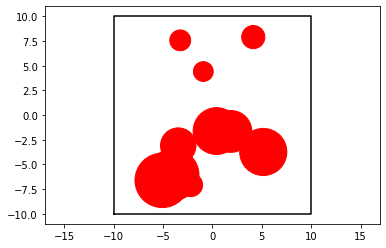

In [260]:
dimension = 2
fill_ratio = 0.4
np.random.seed(1)

lb = np.full((dimension), -10.)
lb[0] = -7
ub = np.full((dimension), 10.)
ub[0] = 7

domain = HPolyhedron.MakeBox([-10.] * dimension, [10.] * dimension)
fill_volume = fill_ratio * (ub[0] - lb[0]) * 20.**(dimension-1.)
obstacles = []
obstacle_volume = 0

lb[0] = -5.5
ub[0] = 5.5
while obstacle_volume < fill_volume:
    center = np.random.rand(dimension) * (ub - lb) + lb
    radius = (np.random.rand(1) + 0.5) * 2.
    tree = Hyperellipsoid.MakeHypersphere(radius, center)
    obstacle_volume += tree.Volume()
    obstacles.append(tree)
    
if dimension == 2:
    fig, ax = plt.subplots()
    ax.plot([-10, 10, 10, -10, -10], [-10, -10, 10, 10, -10], 'k')
    for o in obstacles:
        tree = plt.Circle(o.center(), 1./o.A()[0, 0], color='r')
        ax.add_patch(tree)
    ax.axis('equal')

In [4]:
def evaluatePlanning(plan_fn, seed, iterations):
    np.random.seed(seed)

    data = []
    
    start_lb = np.full((dimension), -10.)
    start_ub = np.full((dimension), 10.)
    start_ub[0] = -7
    goal_lb = np.full((dimension), -10.)
    goal_ub = np.full((dimension), 10.)
    goal_lb[0] = 7
    
    for ii in range(iterations):
        start = np.random.rand(dimension) * (start_ub - start_lb) + start_lb
        goal = np.random.rand(dimension) * (goal_ub - goal_lb) + goal_lb

#         print("Running iteration", ii, flush=True)
        data_dict = dict()
        data_dict["start"] = start
        data_dict["goal"] = goal
                
        start_plan_time = time.time()
        trajectory = plan_fn(start, goal)
        end_plan_time = time.time()
        
        data_dict["found_path"] = trajectory is not None
        data_dict["plan_time"] = end_plan_time - start_plan_time
        if trajectory is not None:
            path_length = 0
            knots = trajectory.vector_values(trajectory.get_segment_times())
            for ii in range(knots.shape[1] - 1):
                path_length += np.linalg.norm(knots[:, ii+1] - knots[:, ii])
            data_dict["path_length"] = path_length

        data.append(data_dict)

    df = pd.DataFrame(data)
    print(df.mean())

# Generate Iris Regions

In [261]:
np.random.seed(10)
iris_options = IrisOptions()
iris_options.require_sample_point_is_contained = True
iris_options.iteration_limit = 5
iris_options.termination_threshold = -1
iris_options.relative_termination_threshold = 0.05

setup_time = time.time()
regions = []

# From random samples
num_regions = len(regions)
num_guesses = 0
lb = np.full((dimension), -10.)
ub = np.full((dimension), 10.)
while num_guesses < 10*(10**dimension) and len(regions) < 5**dimension:
    num_guesses += 1
    seed = np.random.rand(dimension) * (ub - lb) + lb
    in_regions = False
    for R in regions:
        if R.PointInSet(seed):
            in_regions = True
            break
    if in_regions:
        continue
    in_collision = False
    for o in obstacles:
        if o.PointInSet(seed):
            in_collision = True
            break
    if in_collision:
        continue
        
    print("Successful seed after", num_guesses, "guesses:", seed, flush=True)
    
    start_time = time.time()
    try:
        hpoly = Iris(obstacles, seed, domain, iris_options)
    except:
        print(seed)
        continue
    num_guesses = 0
    print("Seed:", len(regions), "\tTime:", time.time() - start_time, "\tFaces:", hpoly.b().shape[0], flush=True)
    regions.append(hpoly)
    
print(f"Time: {time.time() - setup_time}s")


Successful seed after 1 guesses: [ 5.42641287 -9.58496101]
[ 5.42641287 -9.58496101]
Successful seed after 2 guesses: [2.6729647  4.97607765]
Seed: 0 	Time: 0.42180609703063965 	Faces: 8
Successful seed after 1 guesses: [-0.02985975 -5.50406709]
Seed: 1 	Time: 0.4136826992034912 	Faces: 8
Successful seed after 1 guesses: [-6.0387427   5.21061424]
Seed: 2 	Time: 0.2919042110443115 	Faces: 8
Successful seed after 2 guesses: [3.70719637 9.06786692]
[3.70719637 9.06786692]
Successful seed after 13 guesses: [ 8.17297762 -3.61527822]
Seed: 3 	Time: 0.27651333808898926 	Faces: 5
Successful seed after 1 guesses: [-8.19081301 -3.98599887]
Seed: 4 	Time: 0.5415616035461426 	Faces: 7
Successful seed after 9 guesses: [ 6.42211316 -6.97695961]
Seed: 5 	Time: 0.409731388092041 	Faces: 6
Successful seed after 1 guesses: [-2.31771103  8.88521424]
Seed: 6 	Time: 0.6823298931121826 	Faces: 8
Successful seed after 4 guesses: [0.69115898 1.80402726]
Seed: 7 	Time: 0.42438387870788574 	Faces: 7
Successful 

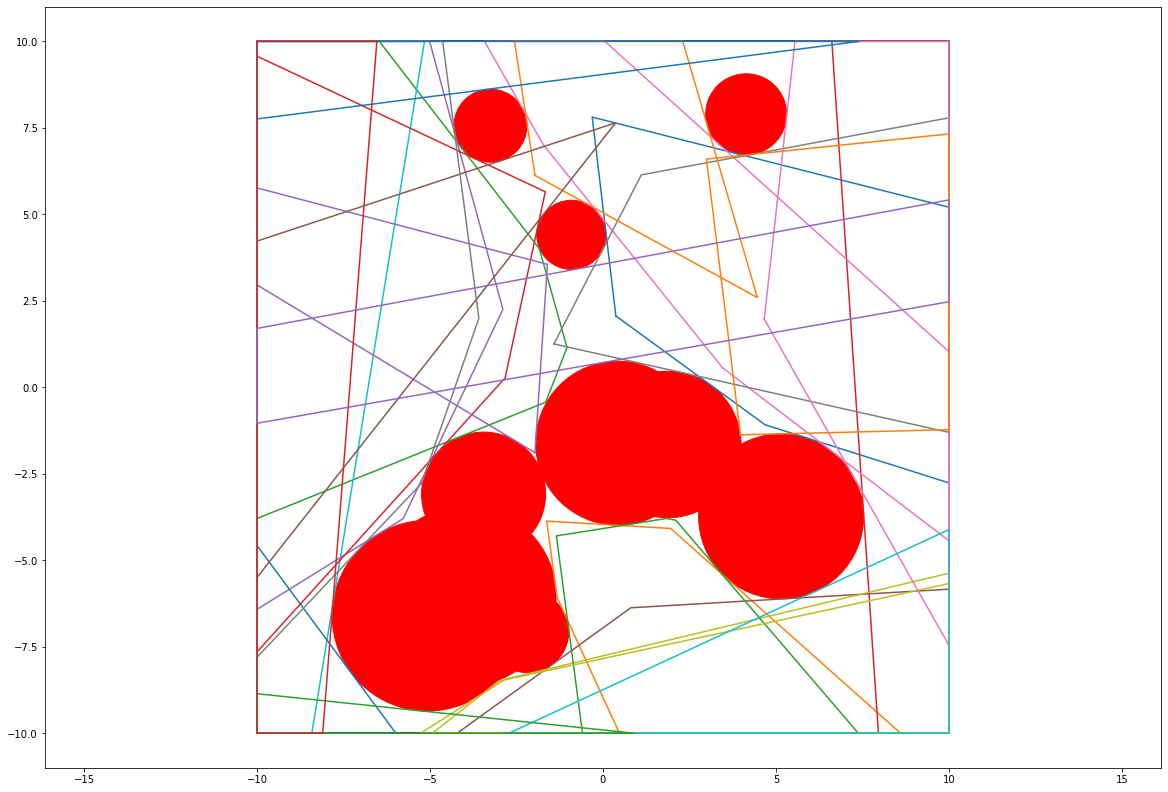

In [262]:
if dimension == 2:
    fig, ax = plt.subplots(figsize=(20, 14))
    ax.plot([-10, 10, 10, -10, -10], [-10, -10, 10, 10, -10], 'k')
    for o in obstacles:
        tree = plt.Circle(o.center(), 1./o.A()[0, 0], color='r')
        ax.add_patch(tree)
    ax.axis('equal')
    for r in regions:
        vert = sorted_vertices(VPolytope(r))
        vert = np.hstack((vert, vert[:, :1]))
        ax.plot(vert[0], vert[1])

# Set up Visibility-based Seeding of IrIs Regions

In [263]:
from functools import partial
from pydrake.all import le, MathematicalProgram, Solve, ge
import networkx as nx
loc_obs = [o.center().reshape(2,1) for o in obstacles]
radii_obs = [1/o.A()[0,0] for o in obstacles]

def is_LOS(q_src, q_targ, eps = 0.3, dist_thresh = 9.0):
    #if np.linalg.norm(q_src-q_targ) > dist_thresh:
    #    return False, None, None, None
    for idx, (loc, radius) in enumerate(zip(loc_obs, radii_obs)):
        prog = MathematicalProgram()
        t = prog.NewContinuousVariables(1, 't')
        prog.AddBoundingBoxConstraint(0, 1, t)
        a = loc - t*q_src - (1-t)*q_targ
        prog.AddConstraint(le(a.T@a, radius**2 + eps ))
        sol = Solve(prog)
        if sol.is_success():
            return False, sol.GetSolution(t), loc, radius
    return True, sol , loc, radius

def col_handle(q, eps = 0.3):
    dim = q.shape[0]
    for obs in obstacles:
        for idx in range(10*dim):
            p = q + eps*(np.random.rand(dim)-0.5)
            if obs.PointInSet(p):
                return True
    return False

def plot_node(q, is_guard, ax):
    if is_guard:
        ax.scatter(q[0],q[1], c = 'g',s = 100 )
    else:
        ax.scatter(q[0],q[1], c = 'k',s = 20 )

def plot_edge(q1, q2, ax, dashed = False):
    if dashed:
        ax.plot([q1[0], q2[0]], [q1[1], q2[1]], c = 'c', linestyle = '--')
    else:
        ax.plot([q1[0], q2[0]], [q1[1], q2[1]], c = 'k')
        
domain = HPolyhedron.MakeBox([-10.] * dimension, [10.] * dimension)

iris_options = IrisOptions()
iris_options.require_sample_point_is_contained = True
iris_options.iteration_limit = 5
iris_options.termination_threshold = -1
iris_options.relative_termination_threshold = 0.05

def morph_iris(pt, obstacles, domain, options):
    return Iris(obstacles, pt, domain, iris_options)

iris_handle = partial(morph_iris, 
                      obstacles = obstacles, 
                      domain = domain, 
                      options = iris_options)
#treat other regions as obstacles 
def morph_iris2(pt, regions, obstacles, domain, options):
    obs = [o for o in obstacles]
    for r in regions:
        offset = 0.25*np.min(1/np.linalg.eig(r.MaximumVolumeInscribedEllipsoid().A())[0])
        rnew = HPolyhedron(r.A(), r.b()-offset)
        obs.append(rnew)
    return Iris(obs, pt, domain, iris_options)

iris_handle2 = partial(morph_iris2, 
                      obstacles = obstacles, 
                      domain = domain, 
                      options = iris_options)   

def plot_scene_connectivity(vs, highlight = None):
    print('red: obstacle, magenta: user seed, blue: guard, green: sampleset')
    fig, ax = plt.subplots(figsize=(20, 14))
    ax.plot([-10, 10, 10, -10, -10], [-10, -10, 10, 10, -10], 'k')
    for o in obstacles:
        tree = plt.Circle(o.center(), 1./o.A()[0, 0], color='r')
        ax.add_patch(tree)
    ax.axis('equal')
    for p in vs.guard_regions:
        tree = plt.Circle(vs.seed_points[p], 0.2, color='b')
        ax.add_patch(tree)
    for p in poi:
        tree = plt.Circle(p, 0.19, color='c')
        ax.add_patch(tree)
    for r in vs.guard_regions:
        vert = sorted_vertices(VPolytope(vs.regions[r]))
        vert = np.hstack((vert, vert[:, :1]))
        ax.plot(vert[0], vert[1], c = 'k', linewidth = 4)    
    components = [list(a) for a in nx.connected_components(vs.connectivity_graph)]
    for component in components:
        pts = [vs.seed_points[c] for c in component]
        if len(pts)>1:
            for idx in range(len(pts)):
                pt1 = pts[idx]
                pt2 = pts[(idx+1) % len(pts)]
                ax.plot([pt1[0], pt2[0]], [pt1[1], pt2[1]], linestyle = 'dotted', linewidth = 4, color = 'k')
    for idx_key, key in enumerate(vs.samples_outside_regions.keys()):
        vis_components = 0
        target_points = []
        for component in components:
            vis_regions = vs.samples_outside_regions[key][1]
            vis_regions_idx = [vs.regions.index(r) for r in vis_regions]
#             print('seed', vis_regions_idx)
#             print('component', component)
#             print('int', len(list(set(vis_regions_idx) & set(component))))
#             print(set(vis_regions_idx))
#             print(set(component))
#             print(set(vis_regions_idx) & set(component))
#             print(list(set(vis_regions_idx) & set(component)))
            if len(list(set(vis_regions_idx) & set(component))):
                vis_components +=1
                target_points.append(list(set(vis_regions_idx) & set(component))[0])
        p = vs.samples_outside_regions[key][0]
        #num_conn = len(vs.samples_outside_regions[key][1])
        #print(vis_components)
        tree = plt.Circle(p, vis_components*0.1, color='g')
        
        if idx_key == highlight:
            tree = plt.Circle(p, vis_components*0.05, color='m')
        ax.add_patch(tree)
        for t in target_points:
            ax.plot([p[0], vs.seed_points[t][0]],[p[1], vs.seed_points[t][1]], c = 'k', linewidth = 0.2)
    for r in range(len(vs.regions)):
        if r>= len(vs.guard_regions):
            vert = sorted_vertices(VPolytope(vs.regions[r]))
            vert = np.hstack((vert, vert[:, :1]))
            ax.plot(vert[0], vert[1], c = 'm', linewidth = 2)
            tree = plt.Circle(vs.seed_points[r], 0.2, color='m')
            ax.add_patch(tree)
            
    
        

In [264]:
from visprm import VPRMSeeding
poi = [np.array([-6, 0]), np.array([0, 8]), np.array([4, -7.5])]
np.random.seed(10)
vs = VPRMSeeding(poi,
                 alpha = 0.1,
                 limits = [lb, ub],
                 collision_handle = col_handle,
                 is_in_line_of_sight = is_LOS, 
                 iris_handle=iris_handle,
                 iris_handle_with_obstacles = iris_handle2,
                 )
vs.set_guard_regions()



[VPRMSeeding] GuardInsertion attempts M: 44


In [265]:
vs.guard_phase()

15
[VPRMSeeding] New guard placed N =  3
[VPRMSeeding] Mosek failed, deleting point
16
[VPRMSeeding] New guard placed N =  3
42
[VPRMSeeding] New guard placed N =  4
[VPRMSeeding] Mosek failed, deleting point


red: obstacle, magenta: user seed, blue: guard, green: sampleset


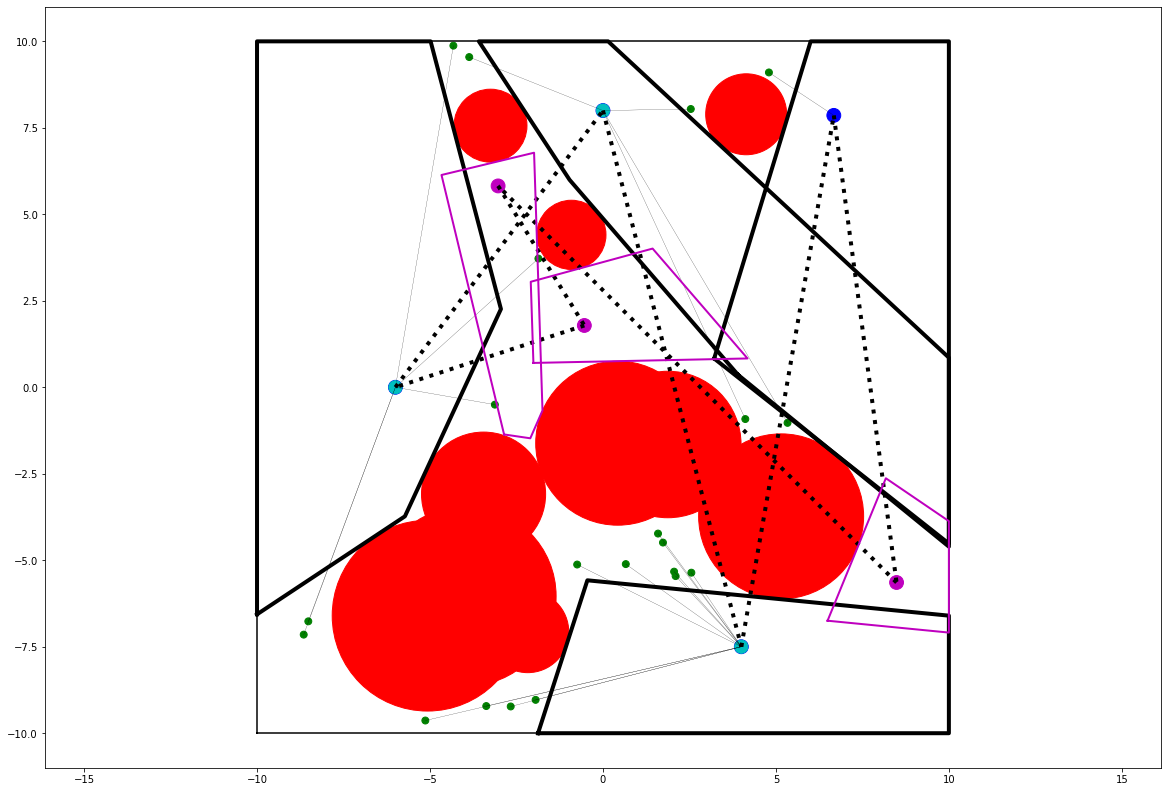

connectivity


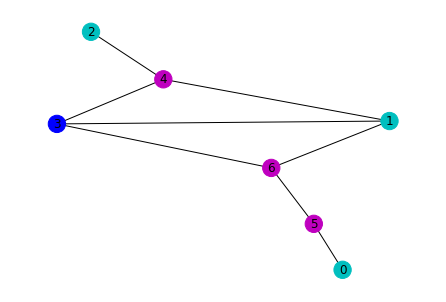

In [270]:
vs.connectivity_phase()
plot_scene_connectivity(vs)
plt.show()
print('connectivity')
vs.draw_connectivity_graph()


In [215]:
#checking coverage
n_vis_samples = 5000
def sample_node_pos(dim, limits, col_handle, MAXIT = 1e4):
        min_pos = limits[0]
        max_pos = limits[1]
        min_max_diff = max_pos - min_pos 
        rand = np.random.rand(dim)
        pos_samp = min_pos + rand*min_max_diff 
        good_sample = not col_handle(pos_samp)

        it = 0
        while not good_sample and it < MAXIT:
            rand = np.random.rand(dim)
            pos_samp = min_pos + rand*min_max_diff 
            good_sample = not col_handle(pos_samp)
            it+=1

        if not good_sample:
            raise ValueError("Could not find collision free point in MAXIT")
        return pos_samp
    
samples = [sample_node_pos(2, [lb, ub], col_handle, MAXIT = 1e4) for _ in range(n_vis_samples)]

def in_vis_region(q, is_LOS, guard_domains):
    for dom in [guard_domains[0]]:
        for guard in dom:
            if is_LOS(q.reshape(2,1), guard.position.reshape(2,1))[0]:
                return 1
    return 0

n_vis = 0
for idx, s in enumerate(samples):
    if idx%100 ==0:
        print(idx)
    n_vis += in_vis_region(s, is_LOS, vprm.guard_domains)
    
print('empirical coverage', n_vis/n_vis_samples)
print('estimated coverage', 1- 1.0/vprm.M)

0.7920809761714461